In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

df = pd.read_csv(r"C:\Users\alide\PycharmProjects\data-science-intro\data\flat.csv", sep = '\t')
df.set_index("n", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 1 to 2040
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     2040 non-null   int64  
 1   totsp     2040 non-null   int64  
 2   livesp    2040 non-null   int64  
 3   kitsp     2040 non-null   float64
 4   dist      2040 non-null   float64
 5   metrdist  2040 non-null   int64  
 6   walk      2040 non-null   int64  
 7   brick     2040 non-null   int64  
 8   floor     2040 non-null   int64  
 9   code      2040 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 175.3 KB


* n - номер квартиры
* price - цена квартиры в $1000
* totsp - общая площадь квартиры, кв.м
* livesp - жилая площадь квартиры, кв.м
* kitsp - площадь кухни, кв.м
* dist - расстояние от центра в км.
* metrdist - расстояние до метро в минутах
* walk - 1 (пешком на метро), 0 - на транспорте
* brick - 1 (кирпичный, мнолит ж/б, 0 - другой)
* floor - 1 (этаж кроме первого и последнего, 0 - другой)
* code - число от 1 до 8. Каждое число обозначает свой район в котором расположена квартира

* Видим что в данных пропусков нет, и что набор данных состоит из одной целевой зависимой переменной price (цена квартиры) - которую нужно предсказать , а также из 9 различным независимых признаков среди которых три признака бинарные (это walk, brick и floor) и один признак категориальный (code) а остальные признаки непрерывные.
* Теперь познакомимся с данными поближе. Построим на одном графике распределения целевой переменной и признаков

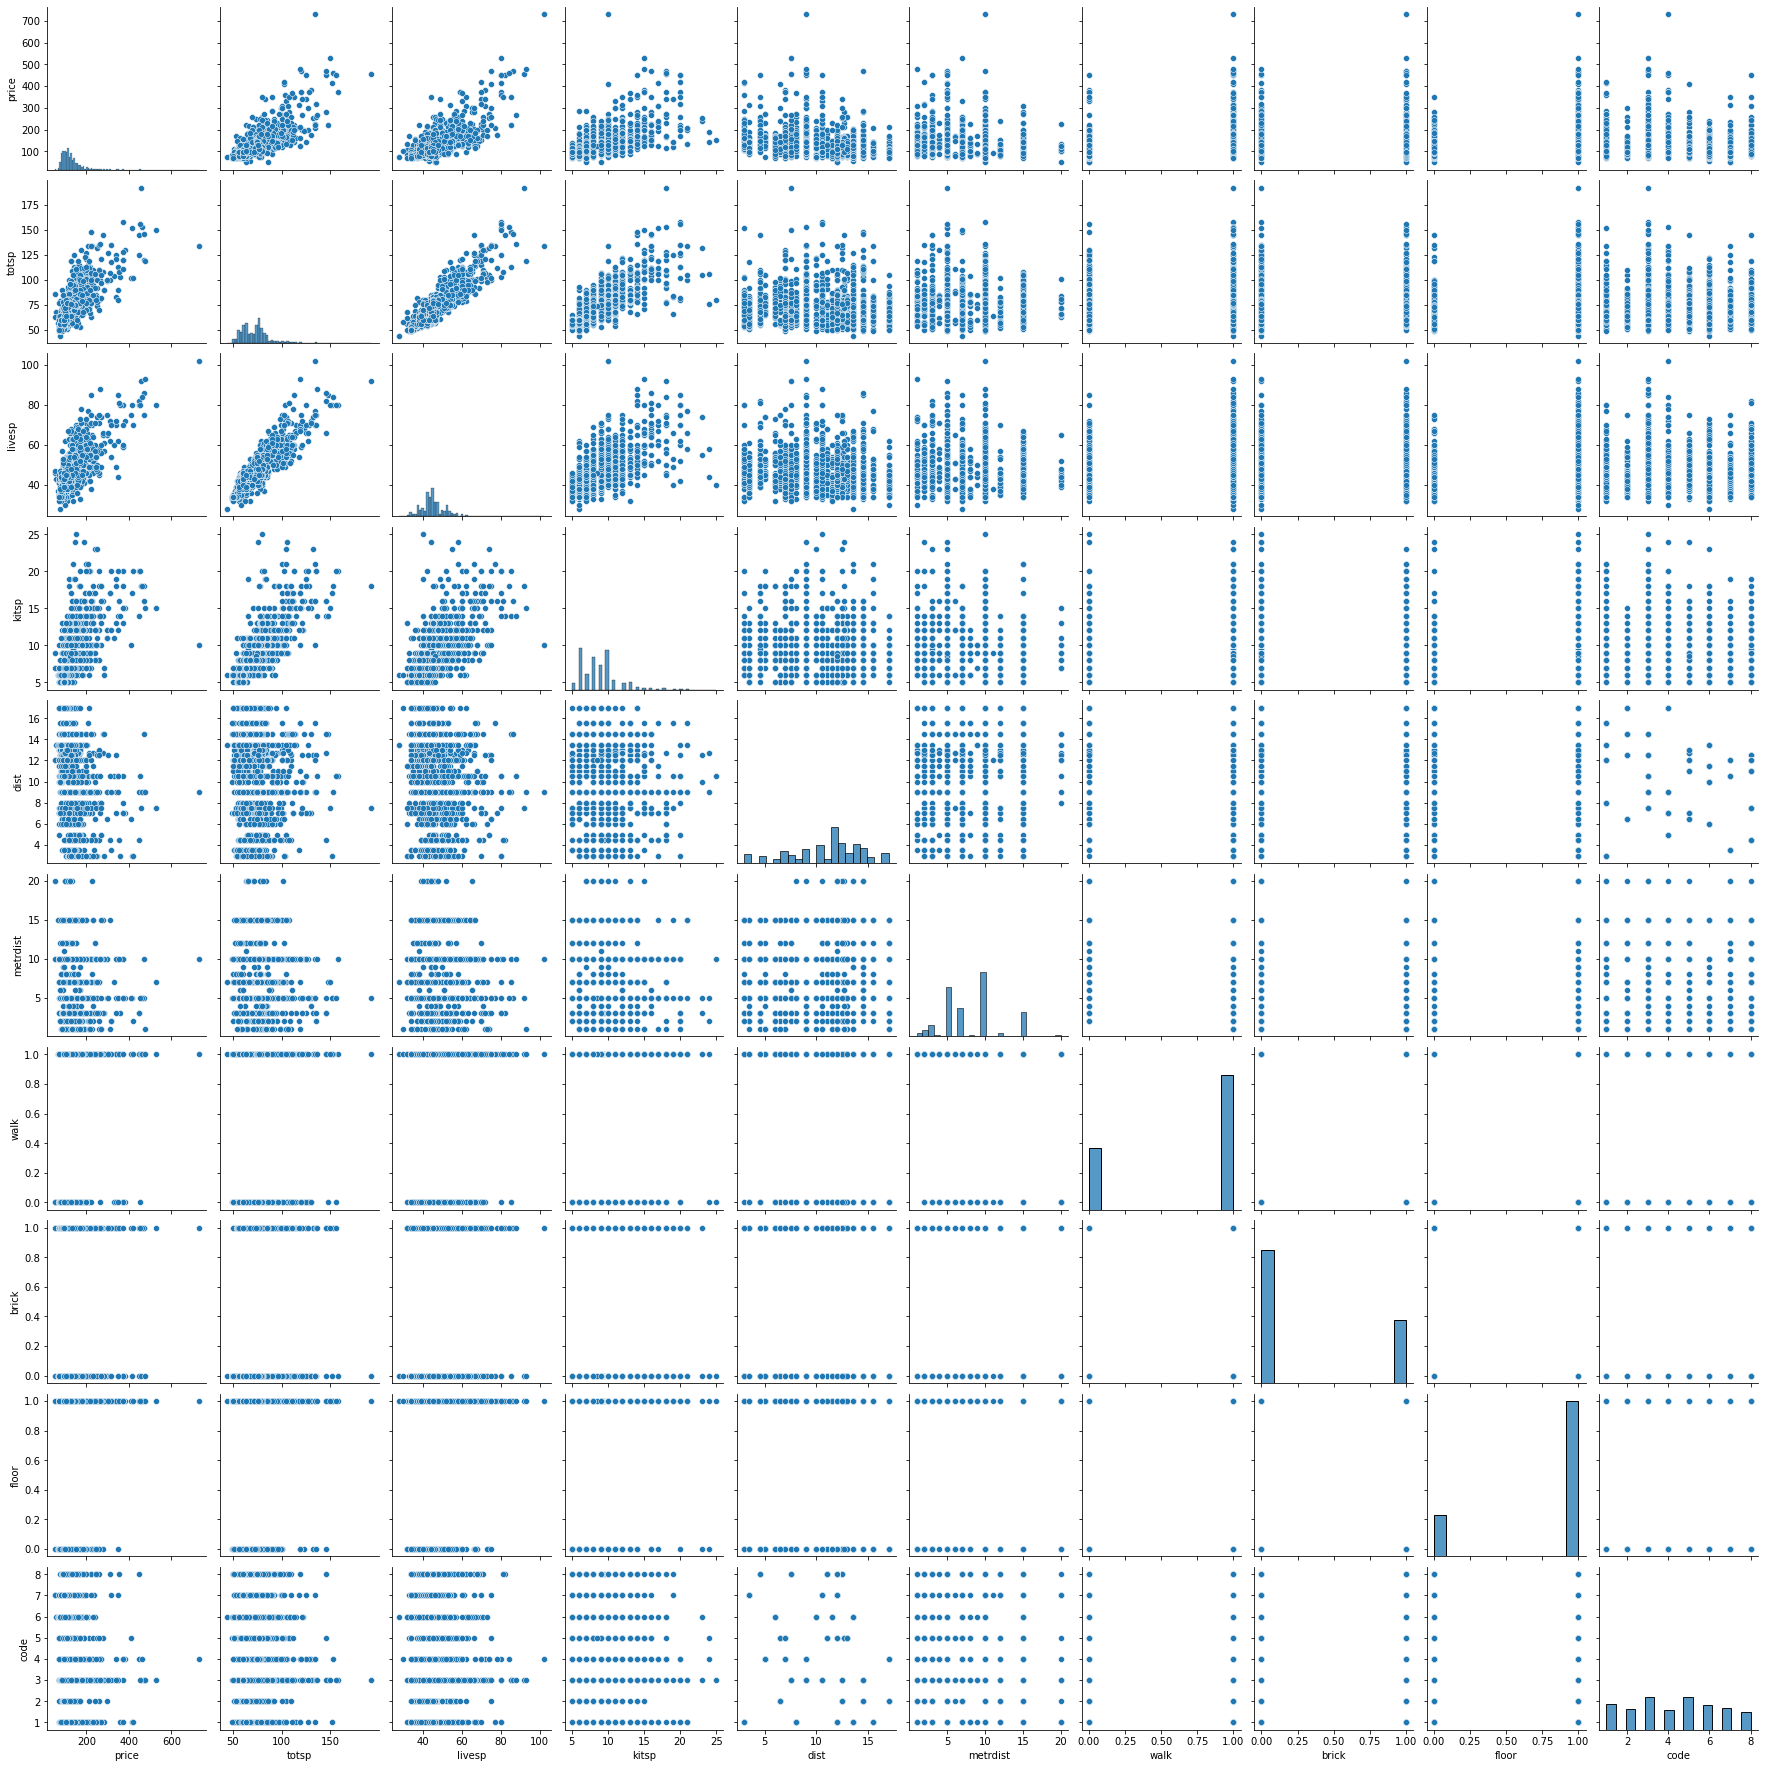

In [3]:
sns.pairplot(df)

сразу видно что целевая переменная имееет линейную зависимость от непрерывных переменных, или похожую на линейную, посмотрим дополнительно на корреляции между price и этими признаками

In [7]:
y = df['price'].copy()
for i in range(1,6):
    print('price corr with {}: {}'.format(df.columns[i], df[df.columns[i]].corr(y)))

price corr with totsp: 0.7560416917044483
price corr with livesp: 0.7296136021085436
price corr with kitsp: 0.5972350743466279
price corr with dist: -0.33156263319867085
price corr with metrdist: -0.15211625119890826


видим что корреляции довольно значимо отличаются от нуля, а в большинстве случаев больше 0.5, поэтому для прогноза будем использовать линейную регрессию. Однако эта модель чувствительная к выбросам как со стороны самой целевой переменной так и со стороны непрерывных признаков. Посмотрим на распределение целевой переменной price

<AxesSubplot:>

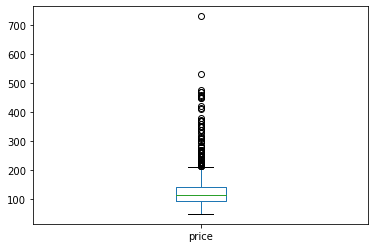

In [8]:
y.plot.box()

<AxesSubplot:>

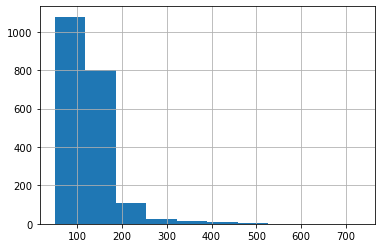

In [9]:
y.hist()

видим что price имеет выбросы, при этом распределение отличается от нормального и похоже на логнормальное (для лучшего результата линейной регрессии желательно чтобы целевая переменная была распределена но нормальному закону). Чтобы решить две проблеммы сразу, применить логарифмическое преобразование, а после это проверим как сохранились линейные зависисимости, для того чтобы можно было использовать линейную регрессию для прогноза уже log(price). Естественно после построения модели применим обратное преобразование.

In [10]:
ylog = np.log(y)
for i in range(1,6):
    print('log(price) corr with {}: {}'.format(df.columns[i], df[df.columns[i]].corr(ylog)))

log(price) corr with totsp: 0.7785888467414173
log(price) corr with livesp: 0.7237282409187376
log(price) corr with kitsp: 0.644984618060101
log(price) corr with dist: -0.3701900885214269
log(price) corr with metrdist: -0.15884388684654785


корреляции существенно не поменялись, т.е сохранилась линейная зависимость между log(price) и непрерывными признаками. Теперь посмотрим есть ли выбросы у непрерывных признаков

<AxesSubplot:>

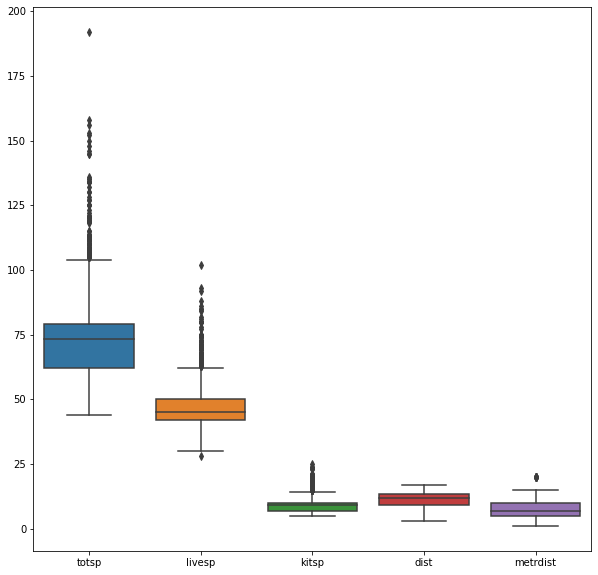

In [11]:
f, axel = plt.subplots(1,1)
f.set(figwidth = 10, figheight = 10)
sns.boxplot(data = df[df.columns[[1,2,3,4,5]]], ax = axel)

Выбросы есть. Очистим данные от выбросов

In [12]:
def outlier_iqr(df, x, threshold):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    up_bound = q3 + threshold * iqr
    low_bound = q1 - threshold * iqr
    up = np.where(x < up_bound)
    low = np.where(x > low_bound)
    index = np.intersect1d(up,low)
    return df.iloc[index]

for i in range(1,6):
    df = outlier_iqr(df,df[df.columns[i]],1.5)

После очистки снова посмотрим на непрерывные признаки

<AxesSubplot:>

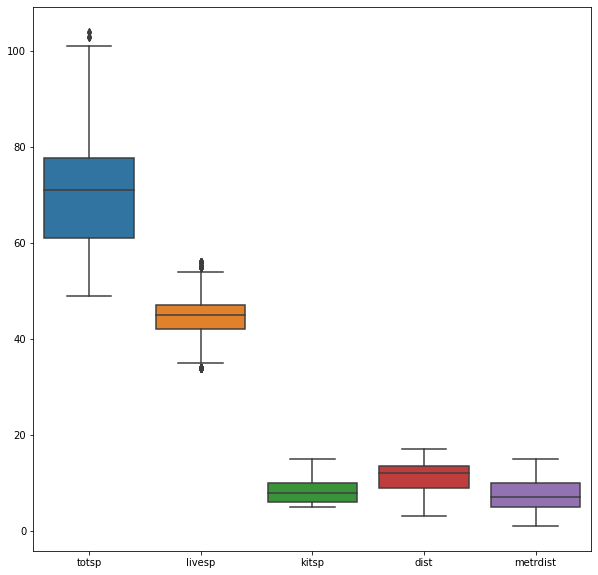

In [13]:
f, axel = plt.subplots(1,1)
f.set(figwidth = 10, figheight = 10)
sns.boxplot(data = df[df.columns[[1,2,3,4,5]]], ax = axel)

выбросы почти исчезли, теперь проверим целевую переменную y = price, после таких преобразований там тоже могут исчезнуть выбросы

<AxesSubplot:>

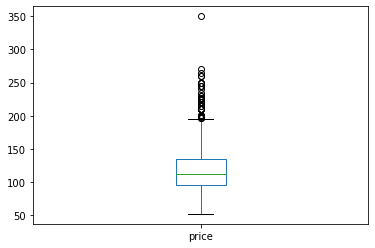

In [14]:
y = df['price'].copy()
y.plot.box()

<AxesSubplot:>

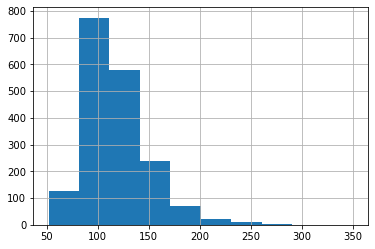

In [15]:
y.hist()

уже лучше, но выбросы всеже есть, снова применим лог преобразование но уже к очищенным данным

<AxesSubplot:>

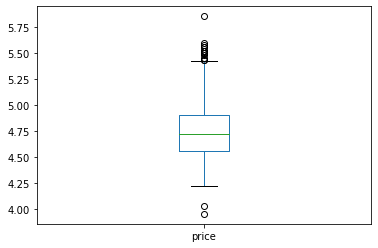

In [16]:
ylog = np.log(y)
ylog.plot.box()

<AxesSubplot:>

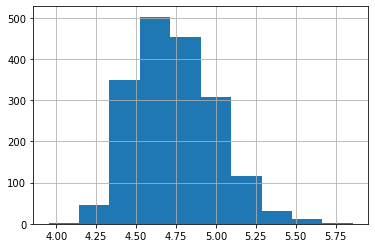

In [17]:
ylog.hist()

теперь после очистки данных от выбросов и лог преобразования, новая целевая переменная ylog выглядит лучше, с этим можно работать. Снова посмотрим на корреляции

In [18]:
for i in range(1,6):
    print('log(price) corr with {}: {}'.format(df.columns[i], df[df.columns[i]].corr(ylog)))

log(price) corr with totsp: 0.6912688623514012
log(price) corr with livesp: 0.5786644679614021
log(price) corr with kitsp: 0.5706392407758138
log(price) corr with dist: -0.3809233103253307
log(price) corr with metrdist: -0.1310333637065008


Продолжаем готовить данные. Осталось преобразовать категориальные прризнаки в числовые, делаем это методом OneHotEncoding

In [19]:
categorial = pd.get_dummies(df['code'],prefix = 'code')
df.drop(['price','code'], axis = 1, inplace = True)
df = pd.concat([df, categorial], axis = 1)
df.reset_index(drop = True, inplace = True)
df.head()

,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code_1,code_2,code_3,code_4,code_5,code_6,code_7,code_8
0,58,40,6.0,12.5,7,1,1,1,0,0,1,0,0,0,0,0
1,70,42,6.0,14.5,3,1,1,1,0,0,1,0,0,0,0,0
2,61,37,6.0,13.5,7,1,0,1,1,0,0,0,0,0,0,0
3,76,50,9.0,11.0,7,1,1,1,0,0,0,0,0,0,0,1
4,59,39,6.0,7.5,10,0,0,1,0,0,0,0,0,0,0,1


## теперь когда данные готовы, строим модель линейной регрессии

In [20]:
scaler = StandardScaler()
dfx = df.to_numpy()
dfy = ylog.to_numpy()
x_train, x_test, ylog_train, ylog_test = train_test_split(dfx, dfy, test_size = 0.25, random_state = 42)
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
print(x_train.shape, x_test.shape, sep = '\n'*2)

(1366, 16)

(456, 16)


In [21]:
# Базовый прогноз baseline
ylog_baseline = np.mean(ylog_train)
ylog_pred_baseline = np.ones_like(ylog_test) * ylog_baseline
ylog_pred_baseline[:5]

array([4.73063347, 4.73063347, 4.73063347, 4.73063347, 4.73063347])

In [22]:
def mape(y_pred, y_test): # расчет средней процентной ошибки
    y1 = y_pred
    y2 = y_test
    t = np.mean(np.abs((y1 - y2) / y2))
    return t * 100

def metrics_show(ylog_pred, ylog_test): # расчет метрик прогнозной модели
    y_pred = np.exp(ylog_pred)
    y_test = np.exp(ylog_test)
    print("средняя процентная ошибка MAPE:", mape(y_pred, y_test))
    print("средняя квадратичная ошибка MSE:", metrics.mean_squared_error(y_pred, y_test))
    print("квадратный корень из средней квадратичной ошибки RMSE:", metrics.mean_squared_error(y_pred, y_test) ** 0.5)
    print("средняя абсолютная ошибка MAE: ", metrics.mean_absolute_error(y_pred, y_test))
    print("R2: ", metrics.r2_score(y_pred, y_test))

print("Метрики до обучения - оценка базового прогноза:", end = '\n'*2)
metrics_show(ylog_pred_baseline, ylog_test)

Метрики до обучения - оценка базового прогноза:

средняя процентная ошибка MAPE: 18.86474404764055
средняя квадратичная ошибка MSE: 1049.7369665491344
квадратный корень из средней квадратичной ошибки RMSE: 32.3996445435615
средняя абсолютная ошибка MAE:  23.44163950521045
R2:  -5.775606318262895e+29


#### Теперь обучим простую линейную модель без регуляризации, и посмотрим на метрики качества прогноза

In [23]:
model_regr = LinearRegression()
model_regr.fit(x_train_scaled, ylog_train)
ylog_pred_regr = model_regr.predict(x_test_scaled)
print("Метрики после обучения модели:", end = '\n'*2)
metrics_show(ylog_pred_regr, ylog_test)

Метрики после обучения модели:

средняя процентная ошибка MAPE: 9.691498333425079
средняя квадратичная ошибка MSE: 327.87951312633766
квадратный корень из средней квадратичной ошибки RMSE: 18.10744358340894
средняя абсолютная ошибка MAE:  12.181715837774398
R2:  0.4633504528453909


Видно, что линейная регрессия улучшила базовый прогноз который равен простому среднему значению всех цен в выборке. Но этот прогноз можно улучшить с помощью модели с регуляризацией

#### Теперь обучим линейную модель регресии Lasso на кросс-валидации (найдем оптимальный гипперпараметр регуляризации), и посмотрим на метрики качества прогноза, сравним с обычной без регуляризации

In [24]:
lasso_cv = LassoCV(cv = 5)
lasso_cv.fit(x_train_scaled, ylog_train)
best_params_cv = lasso_cv.alpha_
print('оптимальные параметры: {}'.format(best_params_cv))

оптимальные параметры: 0.00092879618362331


Делаем прогноз с уже найденным гиперпараметром

In [25]:
ylasso_pred = lasso_cv.predict(x_test_scaled)
print("Метрики после обучения lasso_cv модели:", end = '\n'*2)
metrics_show(ylasso_pred, ylog_test)
print()
model_lasso_cv = pd.DataFrame({"X": df.columns, "w": lasso_cv.coef_})
model_lasso_cv.set_index('X', drop = True, inplace = True)
model_lasso_cv.sort_values(by = "w", inplace=True, ascending=False)
print("model_lasso_cv ", model_lasso_cv, sep = '\n'*2)

Метрики после обучения lasso_cv модели:

средняя процентная ошибка MAPE: 9.703531562221853
средняя квадратичная ошибка MSE: 329.2104074497842
квадратный корень из средней квадратичной ошибки RMSE: 18.144156289279042
средняя абсолютная ошибка MAE:  12.212205769670897
R2:  0.4465855342799655

model_lasso_cv 

                 w
X                 
totsp     0.138194
kitsp     0.045419
walk      0.036997
floor     0.021703
code_3    0.020617
brick     0.018981
code_4    0.015582
code_1    0.012727
code_8    0.009747
livesp    0.000000
code_2   -0.000000
code_7   -0.010792
metrdist -0.027536
code_6   -0.031060
code_5   -0.049433
dist     -0.062713


визуализируем важность признаков: чем больше абсолютное значение у признака - тем он лучше объясняет (предсказывает) линейную регрессию

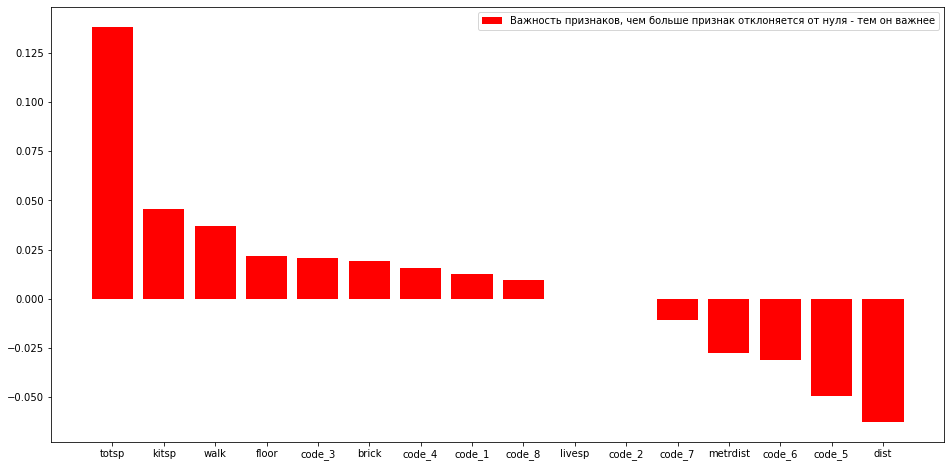

In [26]:
f3, axel3 = plt.subplots(1, 1)
f3.set(figwidth = 16, figheight = 8)
axel3.bar(model_lasso_cv.index, model_lasso_cv["w"], color = "red", label = "Важность признаков, чем больше признак отклоняется от нуля - тем он важнее")
axel3.legend()

* Отсюда видим, что цена квартиры в положительную сторону сильнее всего зависит от общей площади квартиры и от площади кухни:    чем эти показатели больше - тем дороже квартира
* А в отрицательную сторону сильнее всего зависит от района с кодом № 5 и расстояния до центра: чем дальше квартира от центра тем она дешевле, ну и дешевле всего квартиры в районе № 5 при прочих равных параметрах